In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.stats import expon

import pandas as pd

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18

from scipy.optimize import curve_fit


In [2]:
def smooth_speed_calc(speed):
    """
    track by track
    """
    smooth = np.zeros(len(speed))
    for i in range(len(speed)-1):
        smooth[i] = np.sqrt(speed[i]*speed[i+1])
    smooth[-1] = speed[-1]
    return smooth


In [3]:
def mov_not_mov(A,th,zero_th=False):
    """
    Calculate moving and non moving steps.
    
    Parameters
    -----------
    A = array with the values to be analyzed, it can be the smoothed speed or the speed 
    
    th = threshold (taken from the prob of moving and prob of not moving)
    
    Return
    -------
    
    tuple: 
    
    (ns,ms,signal) = (list with NOT moving steps, list with MOVING steps,binary signal (+1 if this step and the next is above threshold, 0 if below))
     
    """
    
    # mask is an array that in each element has True if the value of array A is less than the threshold
    if zero_th:
        mask = A > th
        signal = [] # binary signal
        n=0 # counter for non moving steps
        m=0 # counter for moving steps
        ns=[] # list with consecutive non moving steps
        ms = [] # list with consecutive moving steps
        
        for i in range(len(A)-1):
            
            if mask[i] == False and mask[i+1] == False: # if this value in A and the next are below the threshold
                
                # print('n=',n)
                if m!=0: # append the current running value of m if we changed from moving to non moving
                    
                    ms.append(m)
                m=0 # reset the counter for moving steps
                signal.append(0) # append 0 to the signal
                n+=1 # begin counting non moving steps
            elif mask[i] == True or mask[i+1] == True: 
                # same as before but with the opposite condition
                if n!=0:
                    
                    ns.append(n)
                n=0
                signal.append(1)
                m+=1
            if i+1 == len(A)-1: 
                # if we are in the last element of A, we append the last values of n,m and the signal
                if mask[i] == False or mask[i+1] == False:
                    signal.append(0)
                    ns.append(n)
                else:
                    signal.append(1)
                    ns.append(m)
    else:
        mask = A <= th
        
        signal = [] # binary signal
        n=0 # counter for non moving steps
        m=0 # counter for moving steps
        ns=[] # list with consecutive non moving steps
        ms = [] # list with consecutive moving steps
        
        for i in range(len(A)-1):
            
            if mask[i] == True and mask[i+1] == True: # if this value in A and the next are below the threshold
                
                # print('n=',n)
                if m!=0: # append the current running value of m if we changed from moving to non moving
                    
                    ms.append(m)
                m=0 # reset the counter for moving steps
                signal.append(0) # append 0 to the signal
                n+=1 # begin counting non moving steps
            elif mask[i] == False or mask[i+1] == False: 
                # same as before but with the opposite condition
                if n!=0:
                    
                    ns.append(n)
                n=0
                signal.append(1)
                m+=1
            if i+1 == len(A)-1: 
                # if we are in the last element of A, we append the last values of n,m and the signal
                if mask[i] == False or mask[i+1] == False:
                    signal.append(1)
                    ms.append(m)
                else:
                    signal.append(0)
                    ns.append(n)

    return ns,ms,signal,mask
            

In [69]:
def autocorrelation(series,from_mean=True):
    """Compute the normalized autocorrelation function of a time series."""
    if from_mean:
        series = np.array(series) - np.mean(series)  # Remove mean
    else:
        series = np.array(series)
    n = len(series)
    norm = np.var(series) * n  # Normalization factor
    result = np.correlate(series, series, mode="full") / norm  # Compute autocorrelation
    return result[n-1:] / result[n-1:][0]

In [5]:
from scipy.stats import fit,norm,lognorm,gamma,kstest

def piecewise_gamma(x, x0, y0, k, theta):
    """
    Piecewise function:
    - Returns y0 for x <= x0
    - Follows a Gamma distribution for x > x0
    
    Parameters:
    x : float or array-like
        Input value(s)
    x0 : float
        Threshold value
    y0 : float
        Fixed value for x <= x0
    k : float
        Shape parameter of the Gamma distribution
    theta : float
        Scale parameter of the Gamma distribution
    
    Returns:
    float or array-like: Evaluated function values
    """
    x = np.asarray(x)  # Ensure x is an array for vectorized operations
    gamma_values = gamma.pdf(x - x0, a=k, scale=theta)  # Gamma PDF shifted by x0
    return np.where(x < x0, y0, gamma_values)



def mean_piecewise(x0, y0, k, theta, a, b):
    """
    Computes the mean of the piecewise function over [a, b].

    Parameters:
    x0 : float
        Threshold separating constant and gamma regions
    y0 : float
        Fixed value for x <= x0
    k : float
        Shape parameter of the Gamma distribution
    theta : float
        Scale parameter of the Gamma distribution
    a, b : float
        Integration limits
    
    Returns:
    float: Mean of the function over [a, b]
    """
    # Constant region integral
    I1 = y0 * (x0 - a)

    # Gamma region integral (expectation of the gamma pdf)
    gamma_mean = k * theta  # Mean of Gamma distribution
    I2 = gamma.cdf(b - x0, a=k, scale=theta) * gamma_mean

    # Compute mean
    return (I1 + I2) / (b - a)

In [6]:
def plot_piece_wise_and_gamma(data,x0_guess,k_guess,theta_guess,variable,title,plot_title=False):
    fig,ax = plt.subplots(1,2,figsize=(9,4))

    a = np.array(data)
    a_no_zero = a[a >0]

    freq, bins = np.histogram(a,bins=80,density=True)
    x = np.linspace(0,max(data),500)

    shape,loc,scale = gamma.fit(a_no_zero,floc=0.0)

    pw_params,pw_cov = curve_fit(piecewise_gamma,bins[:-1],freq,p0=[x0_guess,max(freq),k_guess,theta_guess])
    x0,y0,k,theta = pw_params

    mean_value = mean_piecewise(x0, y0, k, theta, 0, max(data))

    kstest_gamma = kstest(a_no_zero,"gamma",args=gamma.fit(a_no_zero))
    f = ax[1].hist(a_no_zero,bins=len(bins),label=f'avg non zero = {np.mean(a_no_zero):.3f}',color='green',density=True)
    freq2, bins2 = f[0],f[1]
    bin_center = 0.5*(bins2[1:] + bins2[:-1])
    max_prob = max(freq2)
    bin_max = bin_center[freq2 == max_prob][0]

    xmin,xmax = ax[1].set_xlim()
    x = np.linspace(xmin, xmax, 100)
    pdf = gamma.pdf(x, shape, loc, scale)
    ax[1].plot(x,pdf,ls='--',lw=1.1,color='black',label=f"Gamma fit: shape={shape:.2f},\n scale={scale:.2f},\n avg fit = {scale*shape:.3f}")
    
    ax[0].hist(data,bins=len(bins),label=f'avg = {np.mean(data):.3f}',color='blue',density=True)
    ax[0].plot(x,piecewise_gamma(x,*pw_params),ls='--',c='black',lw=1.2,label=f'x0 = {x0:.3f},\n scale = {theta:.3f},\n shape = {k:.3f},\n avg fit = {mean_value:.3f}')
    # ax[0].vlines(bin_max,0,max(freq),lw = 0.9,color=' red',alpha = 0.9,label = f'local max = {bin_max:.1f}')
    # ax[0].set_xlim(0,0.1)
    
    

    for axe in ax:
        axe.vlines(bin_max,0,max(freq),lw = 0.9,color='red',alpha = 0.9,label = f'local max = {bin_max:.4f}')
        axe.vlines(np.mean(data),0,max(freq),lw = 0.9,color='pink',alpha = 0.9,label = f'mean= {np.mean(data):.4f}')


        axe.set_xlabel(variable)
        axe.set_ylabel('Frequency')
        axe.legend(fontsize=10)

    if plot_title:
        fig.suptitle(title,fontsize=15,y=0.9)
        
    plt.tight_layout()

    plt.show()
    return np.mean(data),bin_max



In [7]:
def plot_fit_expon(data,variable,title=None,log_scale=False):
    fig,ax = plt.subplots(figsize=(5,5))

    a = np.array(data)
    freq, bins = np.histogram(a,bins=80,density=True)
    bin_center = 0.5*(bins[1:] + bins[:-1])
    max_prob = max(freq)
    bin_max = bin_center[freq == max_prob][0]
    
    params= expon.fit(data,loc=0.0)
    x = np.linspace(0,max(data),500)
    y = expon.pdf(x,*params)

    ax.hist(data,bins=len(bins),label=f'avg = {np.mean(data):.3f}',color='blue',density=True)
    ax.plot(x,y,lw = 1.0, ls = '--',color='black',label = f'fit = {params[1]:.3f}')
    ax.vlines(bin_max,0,max(freq),lw = 0.9,color='red',alpha = 0.9,label = f'local max = {bin_max:.4f}')
    ax.vlines(np.mean(data),0,max(freq),lw = 0.9,color='pink',alpha = 0.9,label = f'mean')
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=10)
    if title:
        fig.suptitle(title,fontsize=15,y=0.9,x=0.55)
    if log_scale:
        ax.semilogy()
    plt.tight_layout()

    plt.show()
    return np.mean(data),bin_max
        
    
    
    

In [8]:
def plot_moving_not_moving_distributions(mov,not_mov,min_steps,max_steps,title,bins,plot_title=False,log_scale=False):
    
    fig,ax = plt.subplots(figsize=(4,4))
    
    a = np.asarray(not_mov)
    b = np.asarray(mov)
    a = a[(a >= min_steps) & (a <= max_steps)]
    b = b[(b >= min_steps) & (b <= max_steps)]
    if a.size !=0:
        

        
        
        P = expon.fit(a,floc=0.0)
        x = np.linspace(1,a.max(),1000)
        rP = expon.pdf(x,*P)
        freqa,binsa = np.histogram(a,bins=bins,density=True)
        centera = 0.5*(binsa[1:]+binsa[:-1])
        ax.scatter(centera,freqa,label = f'not moving\navg = {np.mean(a):.2f}',color='grey',s=40)
        labela =  f'fit not moving = {P[1]:.2f}'
        ax.plot(x,rP, lw = 1.0, ls = '--',color='black',label = labela)
  
    if b.size !=0:
        
        
        P1 = expon.fit(b,floc=0.0)
        x1 = np.linspace(1,b.max(),1000)
        rP1 = expon.pdf(x1,*P1)
        freqb,binsb = np.histogram(b,bins=bins,density=True)   
        centerb = 0.5*(binsb[1:]+binsb[:-1])
        ax.scatter(centerb,freqb,label = f'moving\navg = {np.mean(b):.2f}',alpha=0.7,color='blue',s=40)
        # ax.hist(a,bins=bins, label = f'not moving\navg = {np.mean(a):.2f}',color='grey',density=True)
        # ax.hist(b,bins=bins, label = f'moving\navg = {np.mean(b):.2f}',alpha=0.7,color='blue',density=True)       

        labelb =  f'fit moving = {P1[1]:.2f}'    
        ax.plot(x1,rP1, lw = 1.0, ls = '--',color='red',label = labelb)
    # ax.set_ylim(min(min(freqa),min(freqb)),max(max(freqa),max(freqb))+0.1)

    ax.legend(fontsize=10,frameon=False,handlelength=1.2)
    ax.set_xlabel('consecutive steps')
    ax.set_xlim(min_steps-3,max_steps+3)
    if plot_title:
        ax.set_title(f'{title}',fontsize=14)
    if log_scale:
        ax.semilogy()
    ax.set_ylabel('Frequency')
    plt.show()
    
    return None
    

In [9]:

from scipy.stats import truncexpon

def plot_trunc_exp_two_series(mov, not_mov,
                              min_steps, max_steps,
                              bins=None,
                              title=None):
    """
    Fit and plot truncated exponentials to two datasets (mov & not_mov).

    - Filters to min_steps ≤ x ≤ max_steps
    - Fits truncexpon with loc=min_steps → returns scale=τ
    - Plots density histograms and model PDFs on a semilogy axis
    """

    # 1) prepare data + bins
    a = np.asarray(not_mov)
    b = np.asarray(mov)
    a = a[(a >= min_steps) & (a <= max_steps)]
    b = b[(b >= min_steps) & (b <= max_steps)]

    if bins is None:
        # integer‐wide bins centered on each step
        bins = np.arange(min_steps - 0.5, max_steps + 1.5, 1.0)

    # 2) fit truncated exponentials
    fit_a = truncexpon.fit(a, floc=min_steps)    # → (c, loc, scale)
    fit_b = truncexpon.fit(b, floc=min_steps)
    
    tau_a = fit_a[2]
    tau_b = fit_b[2]

    # 3) compute normalized histograms
    hist_a, edges = np.histogram(a, bins=bins, density=True)
    centers = 0.5*(edges[:-1] + edges[1:])
    hist_b, _     = np.histogram(b, bins=bins, density=True)

    # 4) build normalized truncated‐exp PDF:
    M, m = max_steps, min_steps
    def pdf_trunc(x, tau):
        Z = 1.0 - np.exp(-(M - m) / tau)
        return np.where(x < m,
                        0.0,
                        (1.0/tau) * np.exp(-(x - m)/tau) / Z)

    xs = np.linspace(m, M, 200)
    ya = truncexpon.pdf(xs,*fit_a)
    yb = truncexpon.pdf(xs,*fit_b)

    # 5) plot everything on semilogy
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(centers, hist_a,   'o', color='grey', label=f'not-moving (hist) N={len(a)}')
    ax.plot(centers, hist_b,   'o', color='blue', alpha=0.7, label=f'moving (hist)   N={len(b)}')
    ax.plot(xs, ya, '-', color='black', label=f'fit not-moving τ={tau_a:.2f}')
    ax.plot(xs, yb, '-', color='red',   label=f'fit moving   τ={tau_b:.2f}')

    ax.set_xlim(m-1, M+1)
    ax.set_yscale('log')
    ax.set_xlabel('consecutive steps')
    ax.set_ylabel('Frequency (density)')
    if title:
        ax.set_title(title,fontsize=15)
    ax.legend(frameon=False, fontsize=10)
    plt.tight_layout()
    plt.show()

    return tau_a, tau_b


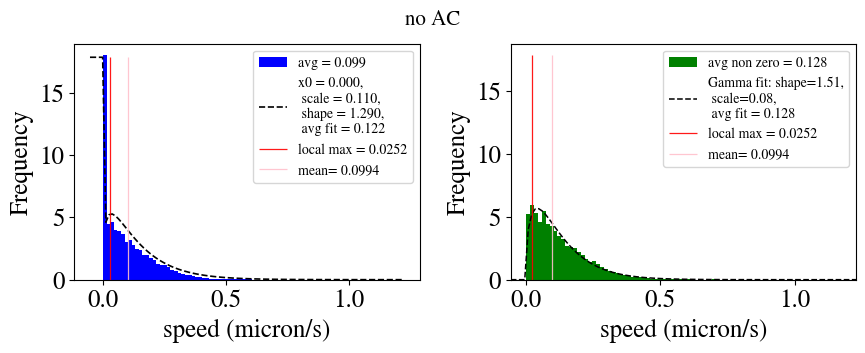

In [10]:
videos = [2,3,4]
speeds_videos = []


for video in videos: 
    
    name = f'data/new-videos/video{video}/video{video}_wspeedsmooth.csv'
    df = pd.read_csv(name,index_col=0)
  
    ids = df['Track ID'].unique()
  
    speeds = df['speed'].values
    speeds_videos += list(speeds)
    
mean_value,local_max = plot_piece_wise_and_gamma(speeds_videos,0.0001,1.29
                          ,0.11,"speed (micron/s)",title = "no AC",plot_title=True)

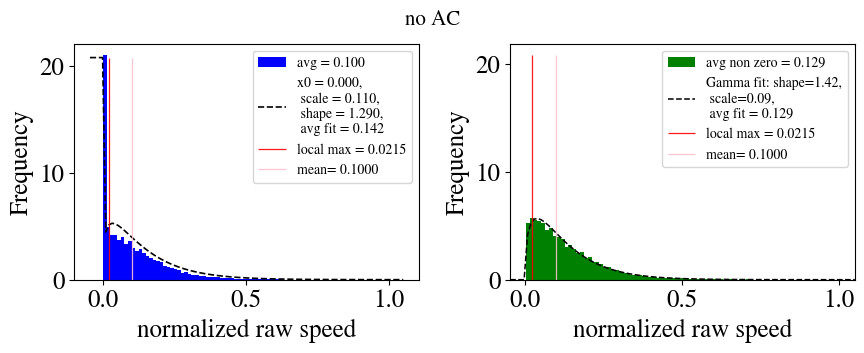

In [11]:
#normalized version
videos = [2,3,4]
speeds_videos = []


for video in videos: 
    
    name = f'data/new-videos/video{video}/video{video}_wspeedsmooth.csv'
    df = pd.read_csv(name,index_col=0)
  
    ids = df['Track ID'].unique()
  
    speeds = df['speed'].values
    speeds_videos += list(speeds/max(speeds))
    
mean_value_normed,local_max_normed = plot_piece_wise_and_gamma(speeds_videos,0.0001,1.29
                          ,0.11,"normalized raw speed",title = "no AC",plot_title=True)

In [12]:
all_videos_mov1,all_videos_mov2,all_videos_mov3 = [],[],[]
all_videos_notmov1,all_videos_notmov2,all_videos_notmov3= [],[],[]
for video in videos: 
    
    name = f'data/new-videos/video{video}/video{video}_wspeedsmooth.csv'
    df = pd.read_csv(name,index_col=0)
  
    ids = df['Track ID'].unique()
    for id in ids:
        traj = df[df['Track ID'] == id].sort_values('Frame')
        speed = traj['speed'].values
        mov,not_mov,_,_ = mov_not_mov(speed,local_max)
        mov2,not_mov2,_,_ = mov_not_mov(speed,mean_value)
        mov3,not_mov3,_,_ = mov_not_mov(speed,0.0,zero_th=True)
        all_videos_mov1 +=mov
        all_videos_mov2 += mov2
        all_videos_mov3 += mov3
        
        all_videos_notmov1 += not_mov
        all_videos_notmov2 += not_mov2
        all_videos_notmov3 += not_mov3
        

        

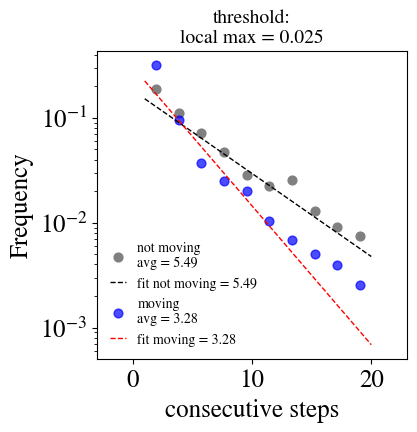

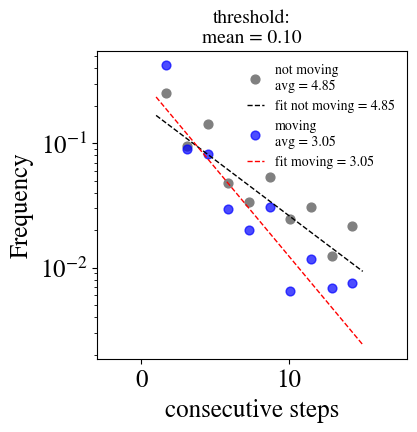

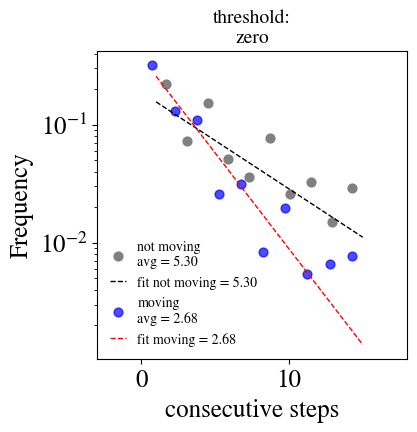

In [13]:
plot_moving_not_moving_distributions(all_videos_mov1,all_videos_notmov1,0,20,f'threshold:\nlocal max = {local_max:.3f}',plot_title=True,bins=10,log_scale=True)
plot_moving_not_moving_distributions(all_videos_mov2,all_videos_notmov2,0,15,f'threshold:\nmean = {mean_value:.2f}',plot_title=True,bins=10,log_scale=True)
plot_moving_not_moving_distributions(all_videos_mov3,all_videos_notmov3,0,15,f'threshold:\nzero',plot_title=True,bins=10,log_scale=True)

Dividing by the max 

In [14]:
mov_normed= [[],[],[]]
not_mov_normed = [[],[],[]]
# thresholds = [mean_value_isolated,local_max_isolated,0.0]
thresholds_2 = {'mean value': mean_value_normed, 'local max': local_max_normed, 'zero':0.0}
names = list(thresholds_2.keys())

for video in videos: 
    
    name = f'data/new-videos/video{video}/video{video}_wspeedsmooth.csv'
    df = pd.read_csv(name,index_col=0)
  
    ids = df['Track ID'].unique()
    for id in ids:
        traj = df[df['Track ID'] == id].sort_values('Frame')
        speed = traj['speed'].values
        sspeed = speed/max(speed)
        for i,name in enumerate(names):
            th = thresholds_2[name]
            # print(f'doing threshold = {th:.4f}')
            if th == 0.0:
                # print('zero')
                no_th = True
            else:
                no_th = False
            not_mov,mov,signal,mask = mov_not_mov(speed,th,zero_th=no_th)
            
            mov_normed[i] += mov
            not_mov_normed[i] += not_mov
        
        
    

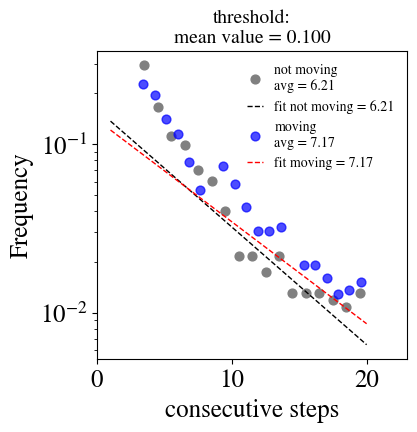

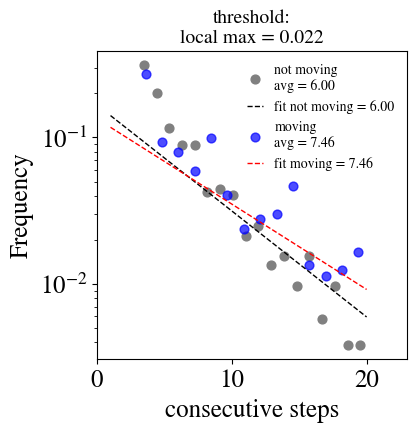

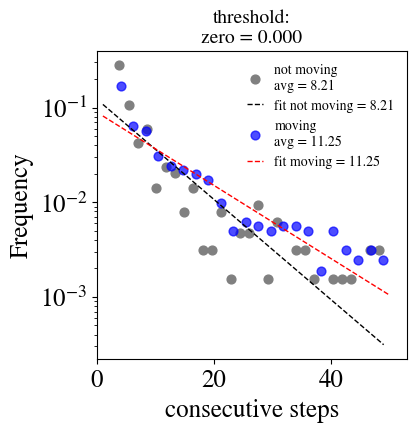

In [15]:
for i,name in enumerate(names):
    th = thresholds_2[name]
    min_steps = 3
    if th ==0:
        max_steps = 50
        log_scale = True
    else:
        max_steps = 20
        log_scale=True
        
    plot_moving_not_moving_distributions(mov_normed[i],not_mov_normed[i],min_steps,max_steps,
                                         f'threshold:\n{name} = {th:.3f}',
                                         plot_title=True,bins='auto',log_scale=log_scale)

Isolated bacteria

In [59]:
dataframe_isolated = pd.read_csv('data/group-trajectories/second_wave/isolated_pairs_video1_v3_wspeeds.csv',index_col = 0)
ids_isolated = dataframe_isolated['Track ID'].unique()

dataframe_isolated

,Track ID,x (micron),y (micron),t (sec),Frame,Info,Obs,vx,vy,speed
Spot ID,,,,,,,,,,
2001,0,32.908503,33.861253,0.000000,0,Isolated,No obs,0.000000,0.000000,0.000000
2064,0,32.882753,33.887003,3.334563,1,Isolated,No obs,-0.007721,0.007721,0.010919
2068,0,32.779753,33.475003,6.669126,2,Isolated,No obs,-0.030885,-0.123538,0.127340
2071,0,32.728253,33.063003,10.003688,3,Isolated,No obs,-0.015442,-0.123538,0.124500
2073,0,32.857003,33.217503,13.338251,4,Isolated,No obs,0.038606,0.046327,0.060304
...,...,...,...,...,...,...,...,...,...,...
17599,18,76.820840,47.225504,650.239749,195,Pairs,In pairs between frames 78 and 139,-0.077211,-0.010295,0.077895
17601,18,76.923840,47.174004,653.574312,196,Pairs,In pairs between frames 78 and 139,0.030885,-0.015442,0.034530
17603,18,77.061174,47.105338,656.908874,197,Pairs,In pairs between frames 78 and 139,0.041179,-0.020590,0.046040


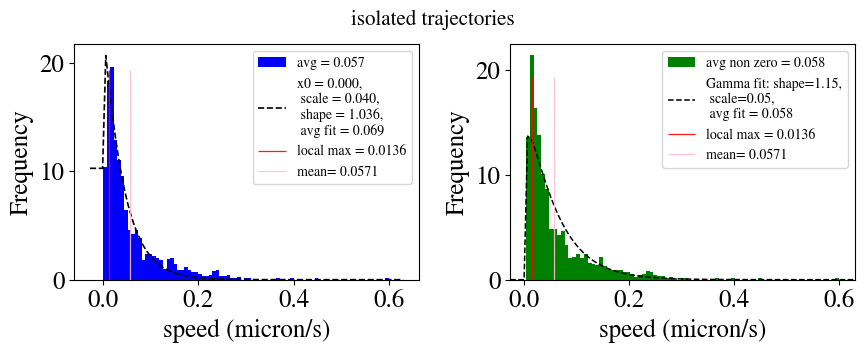

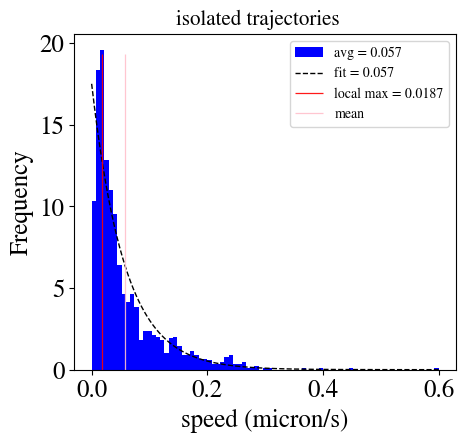

In [64]:
# mov_isolated = []
# not_mov_isolated = []
all_speeds_isolated = []
computed_ids_isolated = []
for id in ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    if traj['Info'].values[0] == "Isolated" and id != 16:
        computed_ids_isolated.append(id)
        obs = traj['Obs'].values[0]
        all_speeds_isolated += list(traj['speed'].values)

plot_piece_wise_and_gamma(all_speeds_isolated,0.0001,1.29
                          ,0.11,"speed (micron/s)",title = "isolated trajectories",plot_title=True)  
mean_value_isolated,local_max_isolated = plot_fit_expon(all_speeds_isolated,"speed (micron/s)",title = 'isolated trajectories',log_scale=False)

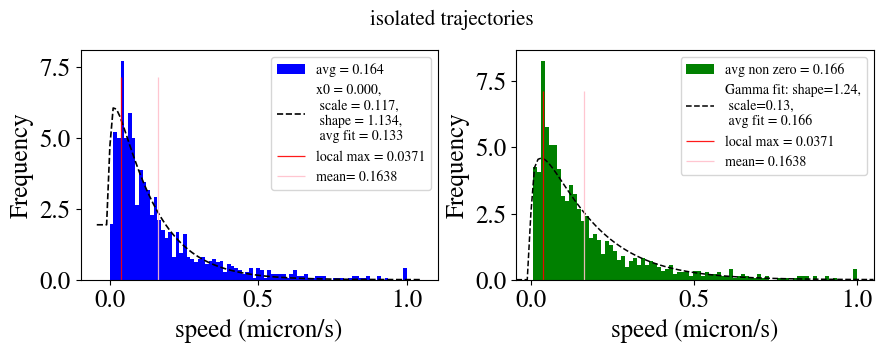

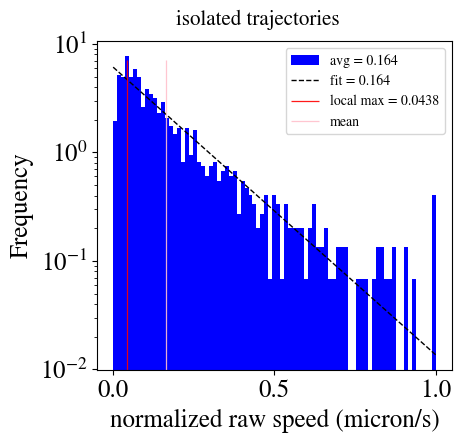

In [18]:
# mov_isolated = []
# not_mov_isolated = []
all_speeds_isolated_normed = []
for id in ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    if traj['Info'].values[0] == "Isolated" and id != 16:
        obs = traj['Obs'].values[0]
        all_speeds_isolated_normed += list(traj['speed'].values/max(traj['speed'].values))

plot_piece_wise_and_gamma(all_speeds_isolated_normed,0.0001,1.29
                          ,0.11,"speed (micron/s)",title = "isolated trajectories",plot_title=True)  
mean_value_isolated_normed,local_max_isolated_normed = plot_fit_expon(all_speeds_isolated_normed,"normalized raw speed (micron/s)",title = 'isolated trajectories',log_scale=True)

In [ ]:
#isolateed trajectories non normalized 

mov_isolated = [[],[],[]]
not_mov_isolated = [[],[],[]]
signal_isolated = [[],[],[]]
speeds = []
# thresholds = [mean_value_isolated,local_max_isolated,0.0]
thresholds_isolated = {'mean value': mean_value_isolated, 'local max': local_max_isolated, 'zero':0.0}
names = list(thresholds_isolated.keys())

for id in computed_ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    # print(f'id = {id}')
    # if traj['Info'].values[0] == "Isolated" and id != 16:
    obs = traj['Obs'].values[0]
    speed = traj['speed'].values
    speeds.append(speed)
    time = traj['Frame'].values
    
    
    for i,name in enumerate(list(thresholds_isolated.keys())):
        th = thresholds_isolated[name]
        # print(f'doing threshold = {th:.4f}')
        if th == 0.0:
            # print('zero')
            no_th = True
        else:
            no_th = False
        not_mov,mov,signal,mask = mov_not_mov(speed,th,zero_th=no_th)
        # plt.figure(figsize=(4,4))
        # plt.plot(time,signal)
        # plt.title(f'isolated\nth = {th:.4f}, id = {id}',fontsize=15)
        # plt.show()
        mov_isolated[i] += mov
        not_mov_isolated[i] += not_mov
        signal_isolated[i].append(signal)



In [66]:
len(signal_isolated[0])

6

In [ ]:
mov_isolated_normed = [[],[],[]]
not_mov_isolated_normed = [[],[],[]]
signals_isolated_normed = [[],[],[]]
# thresholds = [mean_value_isolated,local_max_isolated,0.0]
thresholds_isolated_normed = {'mean value': mean_value_isolated_normed, 'local max': local_max_isolated_normed, 'zero':0.0}
names = list(thresholds_isolated_normed.keys())

for id in ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    # print(f'id = {id}')
    if traj['Info'].values[0] == "Isolated" and id != 16:
        obs = traj['Obs'].values[0]
        speed = traj['speed'].values
        speed = speed/max(speed)
        time = traj['Frame'].values
       
        
        for i,name in enumerate(list(thresholds_isolated_normed.keys())):
            th = thresholds_isolated[name]
            # print(f'doing threshold = {th:.4f}')
            if th == 0.0:
                print('zero')
                no_th = True
            else:
                no_th = False
            not_mov,mov,signal,mask = mov_not_mov(speed,th,zero_th=no_th)
            # plt.figure(figsize=(4,4))
            # plt.plot(time,signal)
            # plt.title(f'isolated\nth = {th:.4f}, id = {id}',fontsize=15)
            # plt.show()
            mov_isolated_normed[i] += mov
            not_mov_isolated_normed[i] += not_mov
            signals_isolated_normed[i].append(signal)

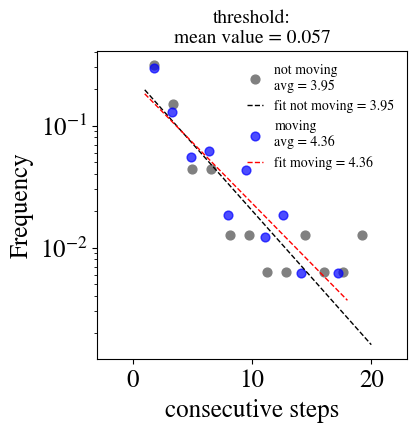

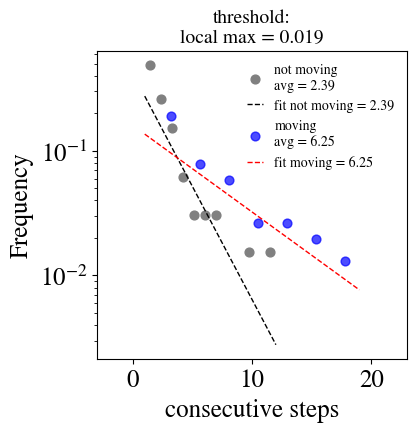

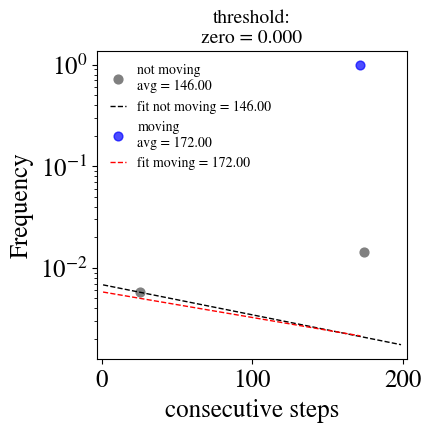

In [21]:
for i,name in enumerate(list(thresholds_isolated.keys())):
    th = thresholds_isolated[name]
    min_steps = 0
    if th ==0:
        max_steps = 200
    else:
        max_steps = 20
    plot_moving_not_moving_distributions(mov_isolated[i],not_mov_isolated[i],min_steps,max_steps,f'threshold:\n{name} = {th:.3f}',plot_title=True,bins='auto',log_scale=True)

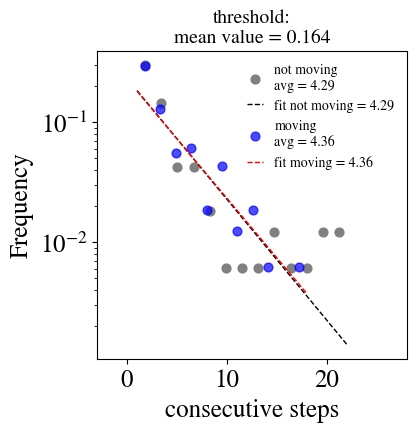

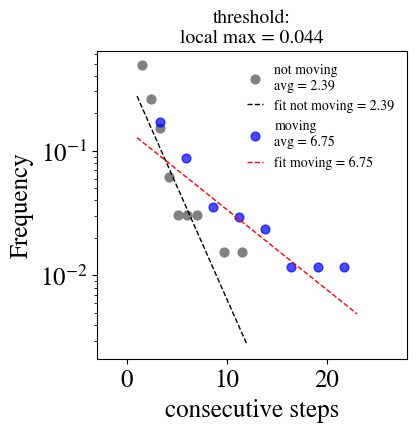

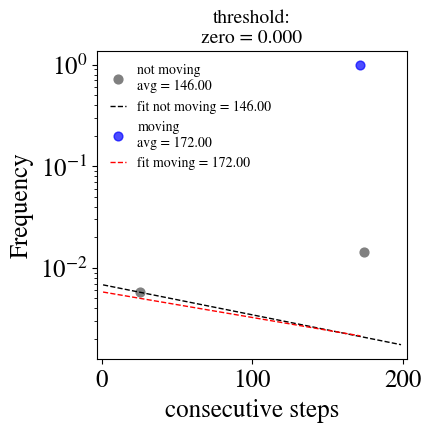

In [22]:
for i,name in enumerate(list(thresholds_isolated_normed.keys())):
    th = thresholds_isolated_normed[name]
    min_steps = 0
    if th ==0:
        max_steps = 200
    else:
        max_steps = 25
    plot_moving_not_moving_distributions(mov_isolated_normed[i],not_mov_isolated_normed[i],min_steps,max_steps,f'threshold:\n{name} = {th:.3f}',plot_title=True,bins='auto',log_scale=True)

Understanding the autocorrelation

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

def fit_autocorrelation(tau, C_tau,title_text='', smooth=True, plot=True, verbose=True,title=True):
    """
    Fit an exponential decay C(tau) = A + B * exp(-lambda * tau) to the autocorrelation function.
    
    Parameters:
        tau (np.ndarray): Time lags.
        C_tau (np.ndarray): Autocorrelation values at the corresponding lags.
        smooth (bool): Whether to apply a smoothing filter before choosing fit region.
        plot (bool): Whether to display the plot.
        verbose (bool): Print fit parameters.
        
    Returns:
        dict: Contains fitted parameters, tau_fit range, and fit function.
    """
    # Smooth the signal to better detect the decay region
    if smooth:
        C_smooth = savgol_filter(C_tau, window_length=15, polyorder=3)
    else:
        C_smooth = C_tau

    # Automatically choose region to fit: find where decay starts
    # C_diff = np.gradient(C_smooth)
    # decay_start = 0  # Heuristic: first significant negative slope

    # # Heuristic end: until correlation is close to noise (e.g., < 10% of max)
    # decay_end = decay_start + np.argmax(C_smooth[decay_start:] < 0.25 * C_smooth[decay_start])

    # # Safety check
    # if decay_end <= decay_start + 3:
    #     decay_end = decay_start + 10
    decay_start=0
    decay_end = 50
    tau_fit = tau[decay_start:decay_end]
    C_fit = C_smooth[decay_start:decay_end]
    

    # Model: C(tau) = A + B exp(-lambda * tau)
    def exp_model(t, A, B, lamb):
        return A + B * np.exp(-lamb * t)

    # Initial guesses
    A0 = C_fit[-1]
    B0 = C_fit[0] - A0
    lamb0 = 1.0 / (tau_fit[-1] - tau_fit[0] + 1e-6)

    try:
        popt, _ = curve_fit(exp_model, tau_fit, C_fit, p0=(A0, B0, lamb0))
        A_fit, B_fit, lambda_fit = popt
    except RuntimeError or RuntimeWarning or ValueError:
        print("⚠️ Fit failed. Try adjusting smoothing or initial guess.")
        return None

    if verbose:
        print(f"Fitted parameters:\n  A = {A_fit:.4f}\n  B = {B_fit:.4f}\n  λ = {lambda_fit:.4f}")
        print(f"Fit region: τ ∈ [{tau_fit[0]:.2f}, {tau_fit[-1]:.2f}]")

    if plot:
        plt.figure(figsize=(5, 4))
        plt.plot(tau, C_tau, label="Original", lw=2)
        plt.plot(tau_fit, exp_model(tau_fit, *popt), 'r--', lw=2, label="Exponential fit")
        plt.axvspan(tau_fit[0], tau_fit[-1], color='gray', alpha=0.2, label="Fit region")
        plt.xlabel(r"$\tau$")
        plt.ylabel(r"$C(\tau)$")
        if title:
            plt.title(title_text,fontsize=12)
        plt.legend(fontsize=12,handlelength=1.5)
        # plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "A": A_fit,
        "B": B_fit,
        "lambda": lambda_fit,
        "tau_fit_range": (tau_fit[0], tau_fit[-1]),
        "fit_function": lambda t: exp_model(t, *popt)
    }

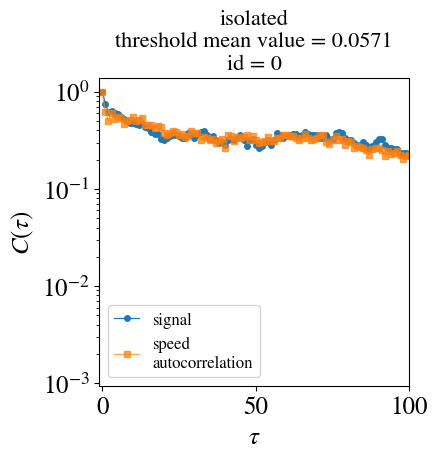

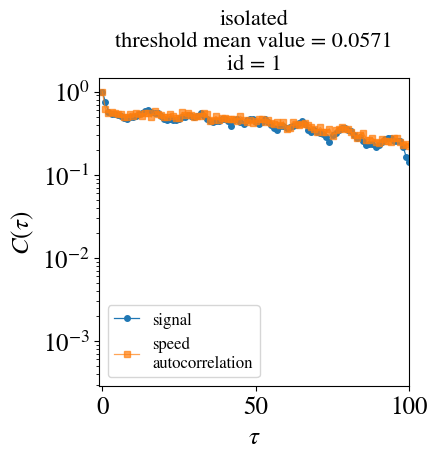

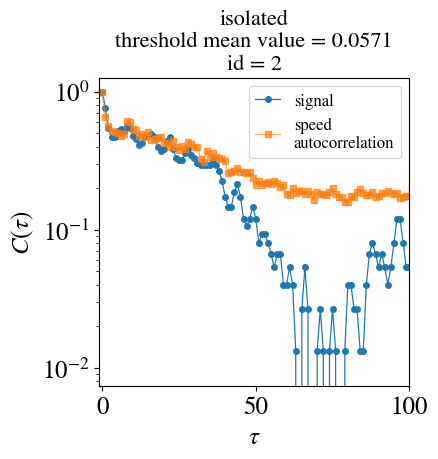

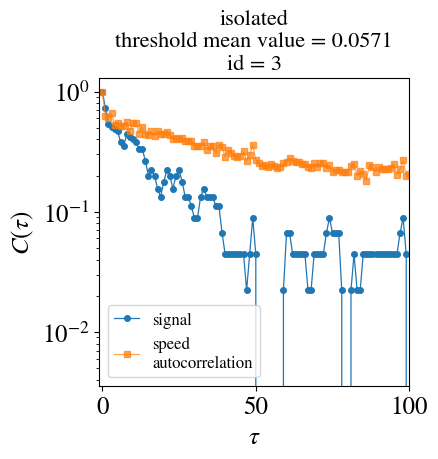

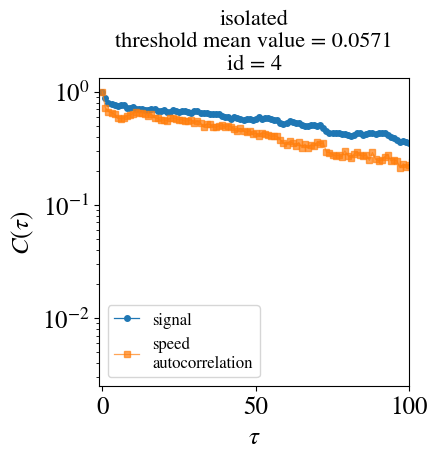

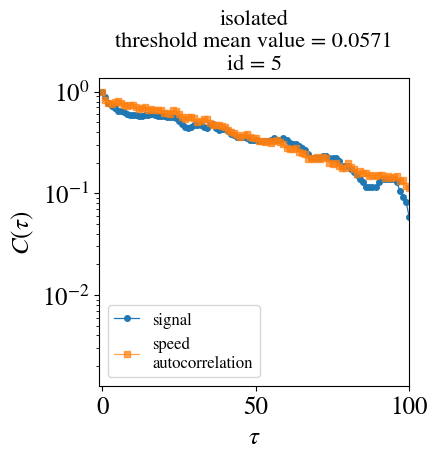

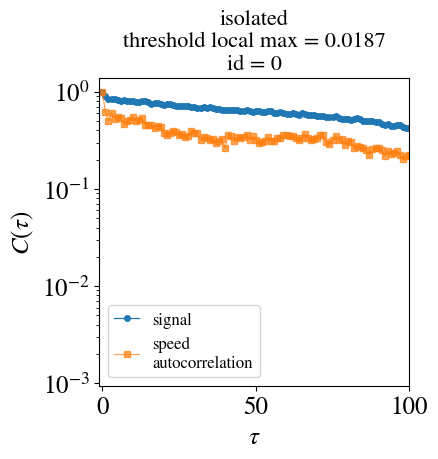

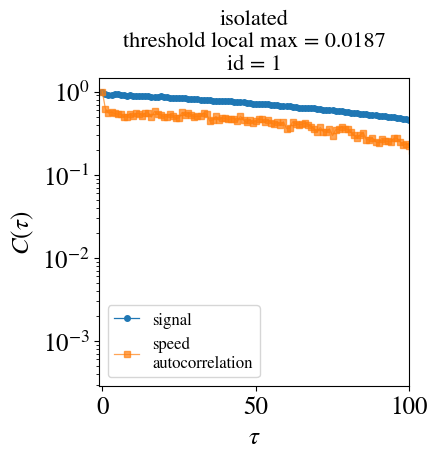

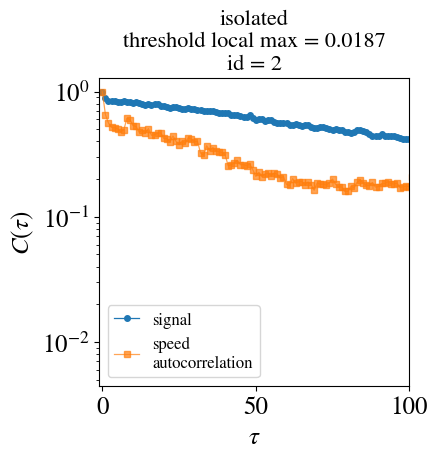

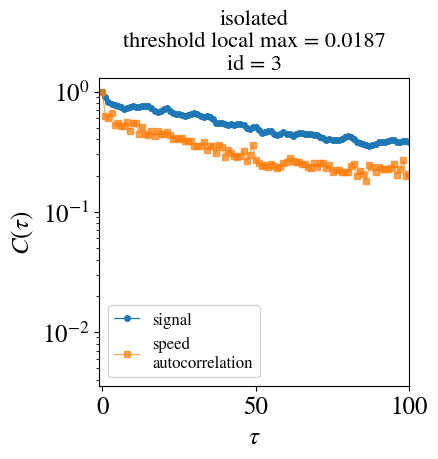

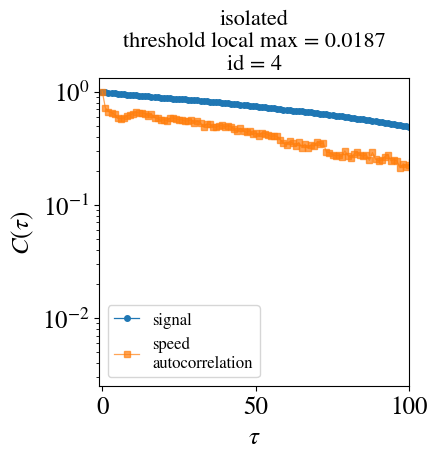

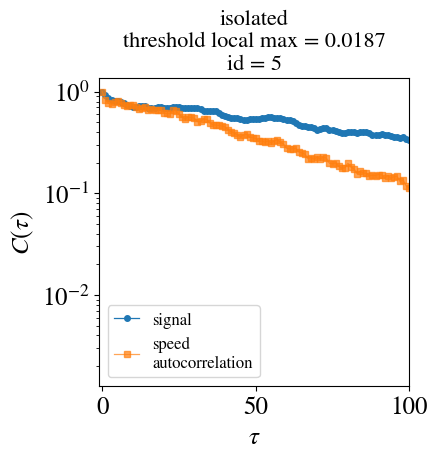

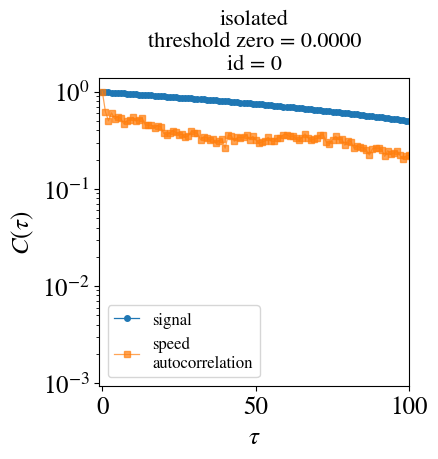

/tmp/ipykernel_7704/1550325631.py:9: RuntimeWarning: divide by zero encountered in divide
  result = np.correlate(series, series, mode="full") / norm  # Compute autocorrelation
/tmp/ipykernel_7704/1550325631.py:10: RuntimeWarning: invalid value encountered in divide
  return result[n-1:] / result[n-1:][0]


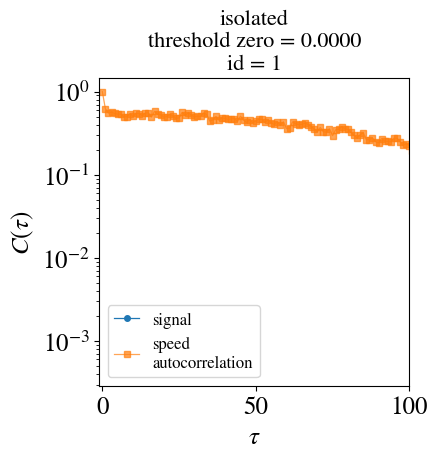

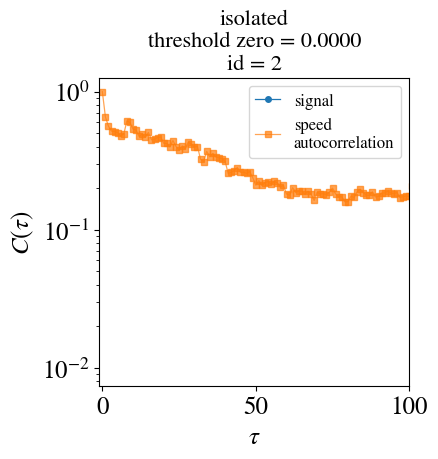

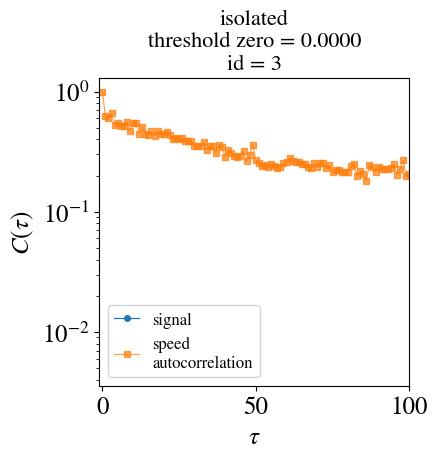

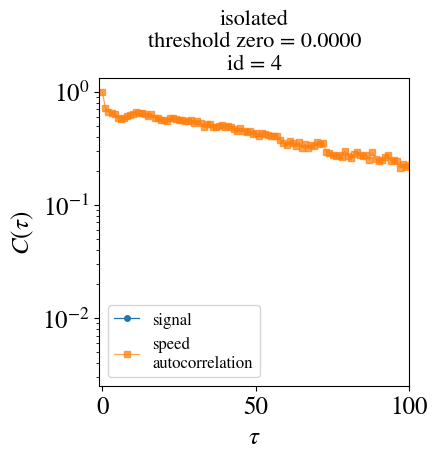

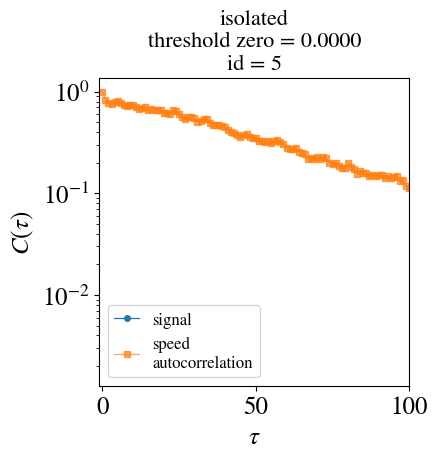

In [73]:
# not from the mean

for i,name in enumerate(list(thresholds_isolated.keys())):
    th = thresholds_isolated[name]
    for j in range(len(computed_ids_isolated)):
        autocorr = autocorrelation(signal_isolated[i][j],from_mean=False)
        lags = np.arange(len(autocorr))
        plt.figure(figsize=(4,4))
        plt.plot(lags,autocorr,marker='o',lw=0.9,ms=4,label = 'signal')
        speed_autocorr = autocorrelation(speeds[j],from_mean=False)
        lags2 = np.arange(len(speed_autocorr))
        plt.plot(lags2,speed_autocorr,marker='s',lw=0.9,ms=4,label = f'speed\nautocorrelation',alpha=0.7)
        plt.xlabel(r'$\tau$')
        plt.ylabel(r'$C(\tau)$')
        plt.title(f'isolated\nthreshold {name} = {th:.4f}\nid = {ids_isolated[j]}',fontsize=16)
        plt.semilogy()
        plt.xlim(-1,100)
        # plt.ylim(0.5,2)
        plt.legend(fontsize=12,handlelength=1.5)
        plt.show()

Fitted parameters:
  A = 0.3309
  B = 0.5362
  λ = 0.1480
Fit region: τ ∈ [0.00, 49.00]


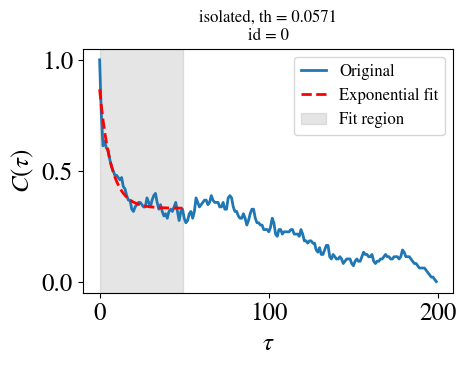

Fitted parameters:
  A = 0.4850
  B = 0.4632
  λ = 0.5448
Fit region: τ ∈ [0.00, 49.00]


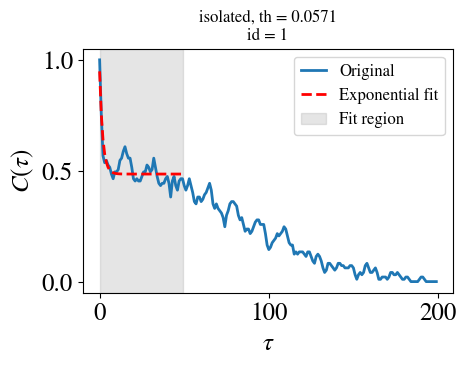

Fitted parameters:
  A = -0.3326
  B = 0.9863
  λ = 0.0147
Fit region: τ ∈ [0.00, 49.00]


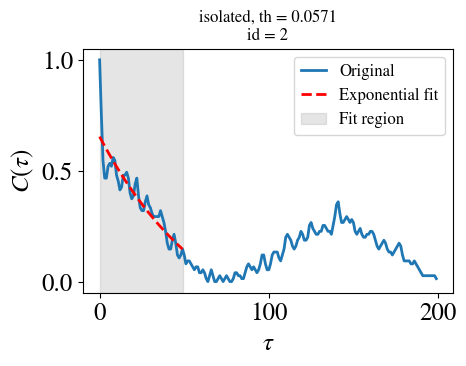

Fitted parameters:
  A = 0.0712
  B = 0.7103
  λ = 0.0966
Fit region: τ ∈ [0.00, 49.00]


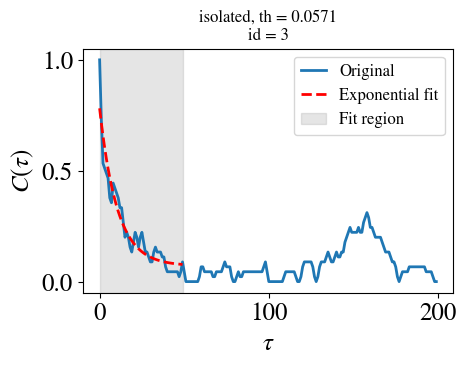

Fitted parameters:
  A = 0.5979
  B = 0.2709
  λ = 0.0693
Fit region: τ ∈ [0.00, 49.00]


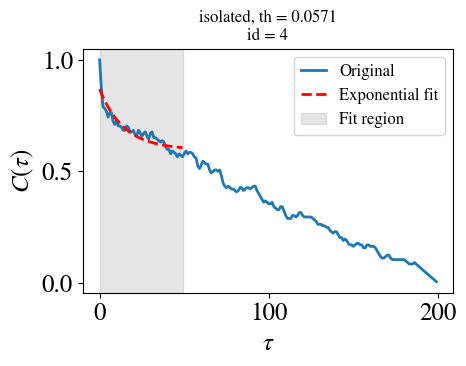

Fitted parameters:
  A = 0.3042
  B = 0.5094
  λ = 0.0401
Fit region: τ ∈ [0.00, 49.00]


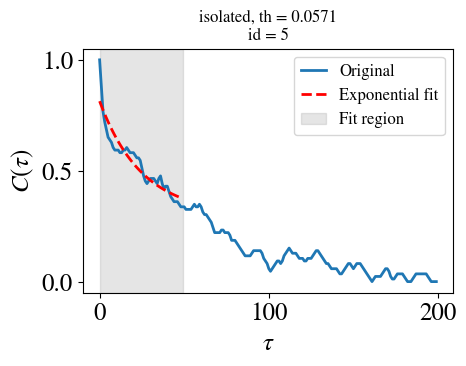

Fitted parameters:
  A = 0.5774
  B = 0.3179
  λ = 0.0345
Fit region: τ ∈ [0.00, 49.00]


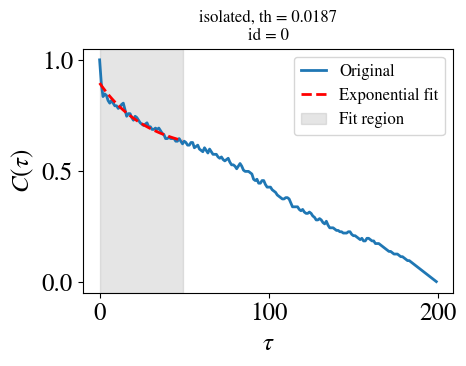

⚠️ Fit failed. Try adjusting smoothing or initial guess.
Fitted parameters:
  A = 0.3448
  B = 0.5473
  λ = 0.0132
Fit region: τ ∈ [0.00, 49.00]


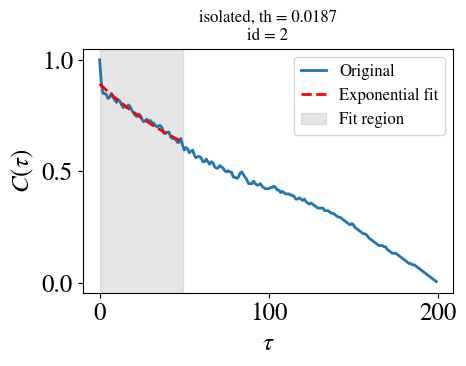

Fitted parameters:
  A = -0.1878
  B = 1.0349
  λ = 0.0082
Fit region: τ ∈ [0.00, 49.00]


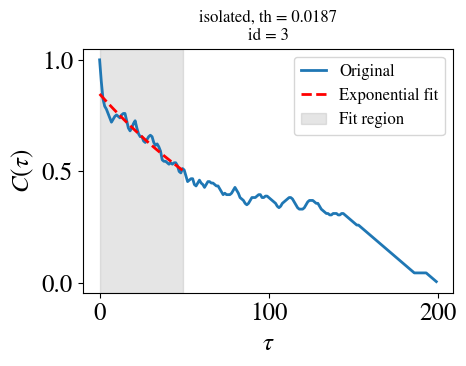

Fitted parameters:
  A = -2.0401
  B = 3.0255
  λ = 0.0017
Fit region: τ ∈ [0.00, 49.00]


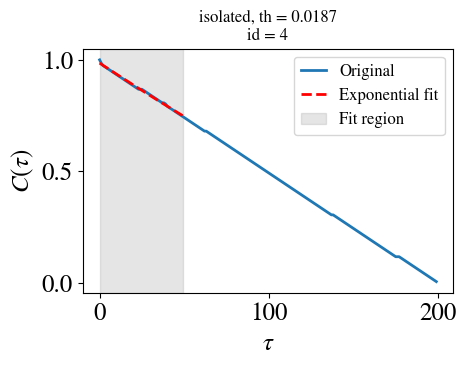

Fitted parameters:
  A = 0.4020
  B = 0.4638
  λ = 0.0223
Fit region: τ ∈ [0.00, 49.00]


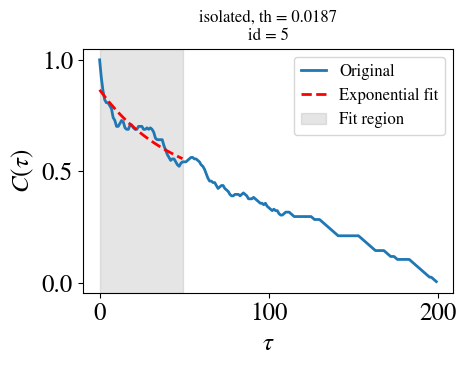

Fitted parameters:
  A = -3.1414
  B = 4.1364
  λ = 0.0012
Fit region: τ ∈ [0.00, 49.00]


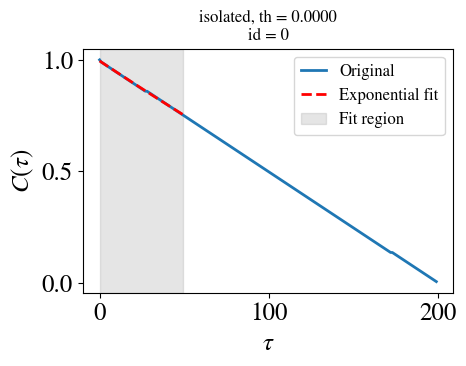

/tmp/ipykernel_7704/1550325631.py:9: RuntimeWarning: divide by zero encountered in divide
  result = np.correlate(series, series, mode="full") / norm  # Compute autocorrelation
/tmp/ipykernel_7704/1550325631.py:10: RuntimeWarning: invalid value encountered in divide
  return result[n-1:] / result[n-1:][0]


ValueError: array must not contain infs or NaNs

In [117]:
for i,name in enumerate(list(thresholds_isolated.keys())):
    th = thresholds_isolated[name]
    for j in range(len(computed_ids_isolated)):
        autocorr = autocorrelation(signal_isolated[i][j],from_mean=False)
        tau = np.arange(len(autocorr))
        fit_autocorrelation(tau, autocorr,title_text=f'isolated, th = {th:.4f}\nid = {computed_ids_isolated[j]}')
        
        
        
        

6


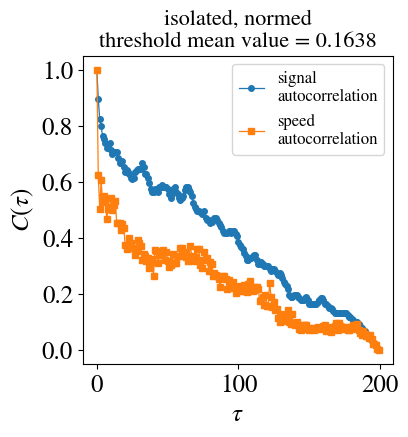

6


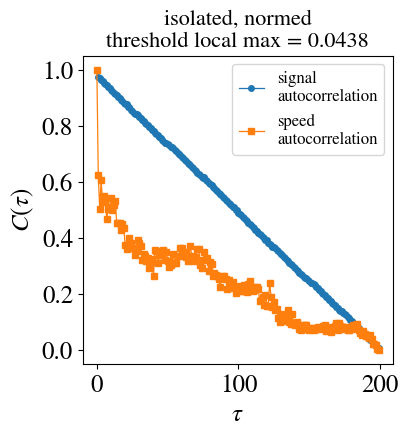

6


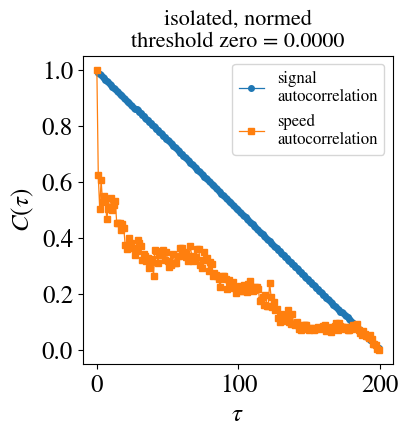

In [71]:
# not from the mean
for i,name in enumerate(list(thresholds_isolated_normed.keys())):
    th = thresholds_isolated_normed[name]
    print(len(signals_isolated_normed[i]))
    autocorr = autocorrelation(signals_isolated_normed[i][0],from_mean=False)
    lags = np.arange(len(autocorr))
    plt.figure(figsize=(4,4))
    plt.plot(lags,autocorr,marker='o',lw=0.9,ms=4,label = f'signal\nautocorrelation')
    
    speed_autocorr = autocorrelation(speeds[0],from_mean=False)
    lags2 = np.arange(len(speed_autocorr))
    plt.plot(lags2,speed_autocorr,marker='s',lw=0.9,ms=4,label = f'speed\nautocorrelation')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$C(\tau)$')
    plt.title(f'isolated, normed\nthreshold {name} = {th:.4f}',fontsize=16)
    # plt.semilogy()
    # plt.xlim(-1,50)
    # plt.ylim(0.5,2)
    plt.legend(fontsize=12,handlelength=1.5)
    plt.show()